## Part I : Select optimal span for loess


#### [Part I 1. Prepare Loess Function](#part1_1)
#### [Part I 2. Test Loess Function](#part1_2)
#### [Part I 3. Results](#part1_3)

<!-- #### [Part I 4. a](#part1_4)
#### [Part I 5. a](#part1_5)
#### [Part I 6. a](#part1_6)
#### [Part I 7. a](#part1_7) -->

### Abbrevations:
- LOESS: Locally Estimated Scatterplot Smoothing
- LOO-CV: Leave One Out- Cross Validation
- GCV: Generalized Cross Validation

### Terminologies:
1. Smoother Matrix:

    - Matrix that maps $y$ to $\hat{y}$
    
    > $\hat{y} = X\hat{\beta} = X_{n x p}(X^{t}X)^{-1}_{p x p}X^{t}_{p x n}y$
    
    > $\hat{y}_{n x 1} = S_{n x n}y_{n x 1}$
    
    - Here, $S= X(X^{t}X)^{-1}X^{t}$ does not depend on y, it only depends on X.


2. Leave One Out Cross Validation:
> $LOO-CV(\hat{f})=\frac{1}{N}\sum_{i=1}^{N}\left[y_i - \hat{f}^{[-i]}(x_i)\right]^2
= \frac{1}{N}\sum_{i=1}^{N}\left[\frac{y_i - \hat{f}(x_i)}{1-S_{\lambda}(i, i)}\right]^2$

    - Where $\hat{f}^{[-i]}$ denotes the model learned based on n-1 samples meaning leaveing the i-th sample out.
    - $S_{i,i}$ is the (i, i)-th entry of the smoothing matrix S.
    - $\hat{f}(x_i)$ is equivalent to $\hat{y}_{i}$
    - This makes LOO-VS faster than general m-fold CV.


3. Generalized Cross Validation:
> $GCV(\hat{f})= \frac{1}{N}\sum_{i=1}^{N}\left[\frac{y_i - \hat{f}(x_i)}{1-trace(S)/N}\right]^2$

4. Locally Estimated Scatterplot Smoothing:
    - Here, the tuning parameter is the span
    - Large value of span induces high bias and lower variance, and vice-versa

    > <img src="https://rafalab.github.io/dsbook/ml/img/loess-multi-span-animation.gif" style="height: 400px;">



References:
1. https://liangfgithub.github.io/Notes/lec_W5_NonlinearRegression.pdf
2. https://rafalab.github.io/dsbook/smoothing.html
3. https://towardsdatascience.com/loess-373d43b03564

### Loess Algorithm:

Step 1: Choose neighborhood points
> The $\alpha n$ points, those with $|x_{i} - x|$ smallest, are called the neighborhood of $x_{0}: N(x_{0})$

Step 2: Fit weighted least-squares linear regression
> $\hat{f}(x) = \hat{\beta}_{0} + \hat{\beta}_{1} (x - x_{0})$ is fit in $N(x_{0}$ points

> Cost function $=\sum_{x_{i} \epsilon N(x_0)}w_{i}\left[y_i - \beta_{0} - \beta_{1}(x_i - x_0)\right]^2$

where, $w_i = (1-u^{3}_{i})^3$
with $u_i = \frac{|x_i - x_0|}{max_{N(x_0)} |x_j - x_0|}$
 
 means $w_i = 0$ if $|u| \geqslant 1$ and
 $(1-u^{3}_{i})^3$  if $|u| < 1$
 - Larger distances will have lower weights


### Linear Regression in Loess

The smoother matrix is of the below form:
- Matrix that maps $y$ to $\hat{y}$
    
    > $\hat{y} = X\hat{\beta} = X_{n x p}(X^{t}WX)^{-1}_{p x p}X^{t}W_{p x n}y$
    
    > $\hat{y}_{n x 1} = S_{n x n}y_{n x 1}$
    
    - Here, $S= X(X^{t}WX)^{-1}X^{t}W$ does not depend on y, it only depends on X.
    - The weight matrix W has all the calculated weights in the diagonal with all other elements set to zero.

### <a id='part1_1'>Part I 1.Prepare Loess Function</a>

In [34]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from loess.loess_1d import loess_1d

In [18]:
df = pd.read_csv('Coding3_data.csv')
df.head(2)

,x,y
0,0.009496,2.692822
1,0.039996,0.566787


In [241]:
def tricubic(u):
    """
    u: normalized vector
    1. output array w is created with dimensions equal to the input array
    2. indexing array is created to remain in the function's domain
    """
    w = np.zeros_like(u)
    idx = (u >= -1) & (u <= 1)
    w[idx] = np.power(1.0 - np.power(np.abs(u[idx]), 3), 3)
    return w

class Loess(object):
       
    @staticmethod
    def normalize_array(array):
        """
        function to normalize input array
        """
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val
    
    def __init__(self, xx, yy, degree=0):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree
        
    @staticmethod
    def get_min_range(distances, window):
        """
        distances: array of distances
        window: minimal-distance window
        """
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)
    
    @staticmethod
    def calculate_weights(distances, span):
        """
        distances: array of distances
        span: minimal-distance window
        """
        max_dist = np.max(distances[span])
        weights = tricubic(distances[span] / max_dist)
        return weights
    
    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)
    
    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, degree=0):
        """
        x: new data point
        window: number of nearest values
        wm: weights matrix
        """
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.calculate_weights(distances, min_range)

        wm = np.multiply(np.eye(window), weights)
        # Perform polynomial regression if degree is greater than 1
        xm = np.ones((window, degree + 1))

        xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])
        for i in range(1, degree + 1):
            xm[:, i] = np.power(self.n_xx[min_range], i)

        ym = self.n_yy[min_range]
        xmt_wm = np.transpose(xm) @ wm
        beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
        y = (beta @ xp)[0]

            
        return self.denormalize_y(y)
    
    def smoother_matrix(self, X):
        """
        Compute the diagonal entrie of the smoother matrix S and store it in a vector 'lev'
        x1: n-by-1 feature vector
        sp: a numerical value for 'span'

        """
        hat = X.dot(np.linalg.inv(X.T.dot(X)).dot(X.T))
        lev = np.diagonal(hat)
        return lev

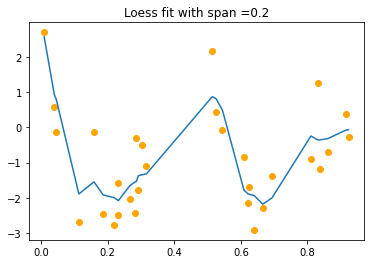

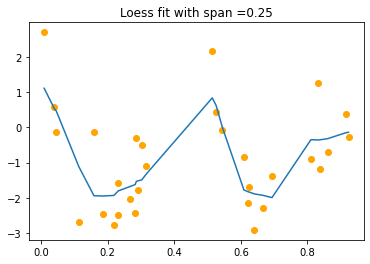

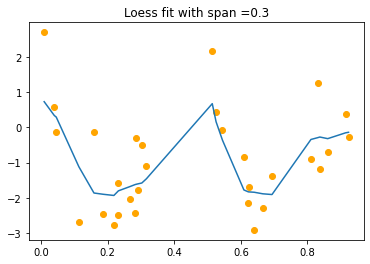

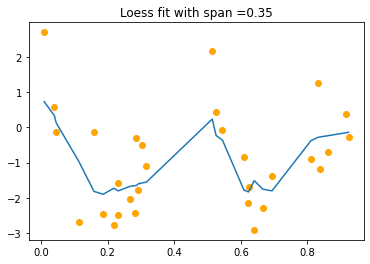

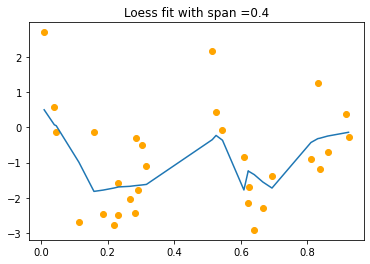

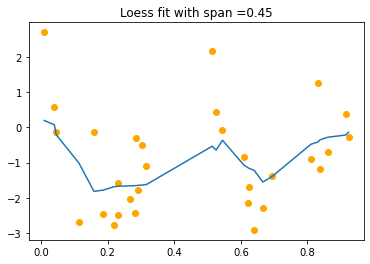

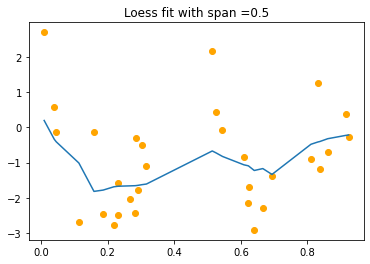

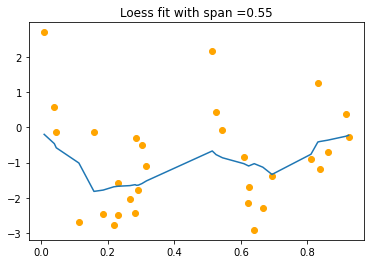

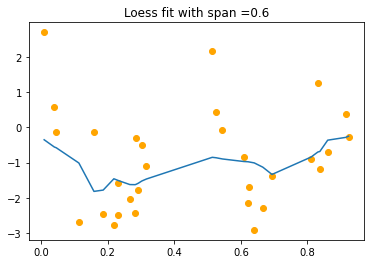

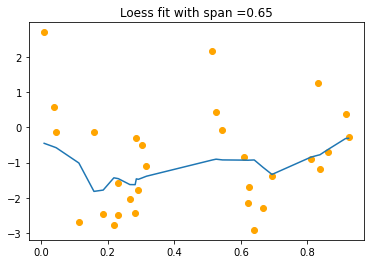

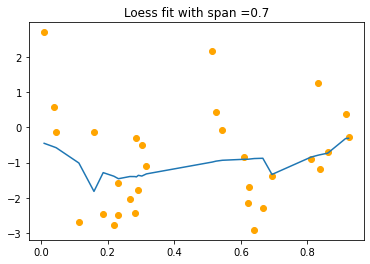

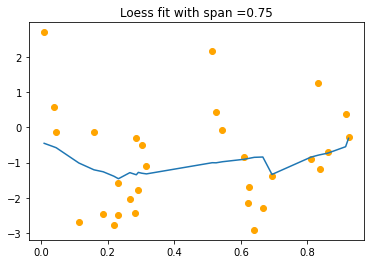

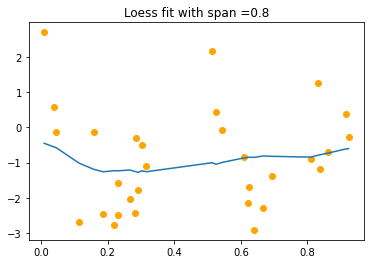

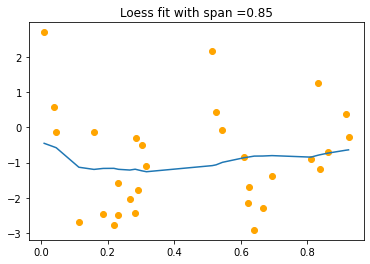

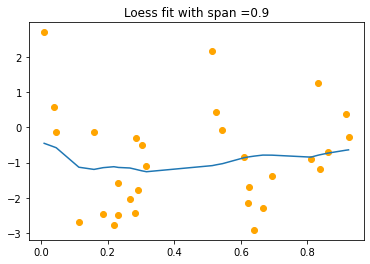

In [200]:
span_range = np.arange(0.20, 0.95, 0.05)
span_range = np.round(span_range,2)

for span in span_range:
    my_pred = {}
    for i in df.x:
        xx = df.x[(df.x >= i-(span/2)) & (df.x <= i+(span/2))]
        yy = df.y[(df.x >= i-(span/2)) & (df.x <= i+(span/2))]
        loess = Loess(xx.tolist(), yy.tolist())
        y_pred = []
        
        y = loess.estimate(i, window=len(xx), degree=0)
        my_pred.update({i:y})
        
    plt.plot(my_pred.keys(), my_pred.values())   
    plt.scatter(df.x, df.y, c='orange')
    plt.title(f'Loess fit with span ={span}')
    plt.show()

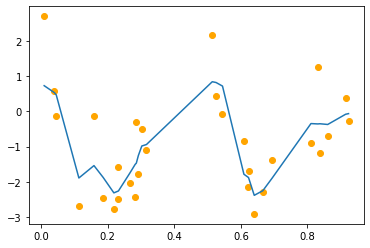

In [140]:
xx = df.x
yy = df.y

loess = Loess(xx, yy)

y_pred = []

for x in xx:
    y = loess.estimate(x, window=5, degree=0)
    y_pred.append(y)

plt.plot(xx, y_pred)   
plt.scatter(xx, yy, c='orange')
plt.show()

In [30]:
np.zeros_like(df.x)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
a.tricubic(df.x)

array([0.99999743, 0.99980807, 0.99971237, 0.99559645, 0.98797899,
       0.98059638, 0.96890408, 0.96289752, 0.96274369, 0.9440881 ,
       0.93371719, 0.93129113, 0.92692222, 0.91908488, 0.90777502,
       0.64498174, 0.62441103, 0.58878347, 0.46337515, 0.43726359,
       0.43509484, 0.40108867, 0.34962819, 0.29585405, 0.10209639,
       0.07699815, 0.07044612, 0.04740286, 0.01294433, 0.00960399])

In [86]:
np.ones((4, 1))

array([[1.],
       [1.],
       [1.],
       [1.]])

In [147]:
yy

24   -0.886643
25    1.266158
26   -1.182924
27   -0.700902
28    0.368869
29   -0.288949
Name: y, dtype: float64

In [148]:
xx

24    0.810599
25    0.831345
26    0.837296
27    0.860915
28    0.914658
29    0.923433
Name: x, dtype: float64

In [149]:
y_pred

[-0.35244688926950707,
 -0.3600760833751677,
 -0.3559626027927715,
 -0.3223125014725,
 -0.15702521876356856,
 -0.14216141592423015]

In [191]:
import numpy as np
rng = np.random.RandomState(42)
n_samples, n_features = 20, 5
X = rng.randn(n_samples, n_features)

hat = X.dot(np.linalg.inv(X.T.dot(X)).dot(X.T))

hat_diag = np.diagonal(hat)
trace = hat_diag.sum()  # this is equal to n_features == 5
print(trace)

only_diag = np.einsum('ij, ij -> j', X.T, np.linalg.inv(X.T.dot(X)).dot(X.T))

print(only_diag == hat_diag.all())  # this evaluates to True

5.0
[False False False False False False False False False False False False
 False False False False False False False False]


In [195]:
hat_diag

array([0.14739985, 0.2922631 , 0.34764677, 0.2346982 , 0.42071538,
       0.13168446, 0.34896338, 0.43767396, 0.15495494, 0.28584282,
       0.10952631, 0.15721865, 0.15976061, 0.21408651, 0.60478629,
       0.24156428, 0.24053161, 0.11621046, 0.14225641, 0.21221599])

In [224]:
X = df.x.to_numpy()

In [ ]:
X.dot(np.linalg.inv(X.T.dot(X)).dot(X.T))

In [232]:
inverse = 1/(X.T.dot(X))
np.array([inverse]).dot(X.T)

ValueError: shapes (1,) and (30,) not aligned: 1 (dim 0) != 30 (dim 0)

In [219]:
loess.smoother_matrix(df.x.to_numpy())

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

0.08631753921508789


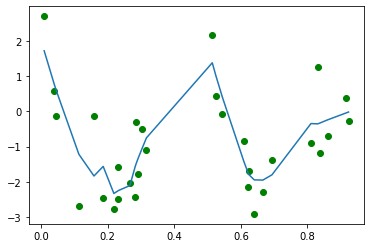

In [36]:
import numpy as np
import time
import math


def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y


class Loess(object):

    @staticmethod
    def normalize_array(array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    def __init__(self, xx, yy, degree=1):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

    @staticmethod
    def get_min_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return weights

    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, use_matrix=False, degree=1):
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.get_weights(distances, min_range)

        if use_matrix or degree > 1:
            wm = np.multiply(np.eye(window), weights)
            xm = np.ones((window, degree + 1))

            xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])
            for i in range(1, degree + 1):
                xm[:, i] = np.power(self.n_xx[min_range], i)

            ym = self.n_yy[min_range]
            xmt_wm = np.transpose(xm) @ wm
            beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
            y = (beta @ xp)[0]
        else:
            xx = self.n_xx[min_range]
            yy = self.n_yy[min_range]
            sum_weight = np.sum(weights)
            sum_weight_x = np.dot(xx, weights)
            sum_weight_y = np.dot(yy, weights)
            sum_weight_x2 = np.dot(np.multiply(xx, xx), weights)
            sum_weight_xy = np.dot(np.multiply(xx, yy), weights)

            mean_x = sum_weight_x / sum_weight
            mean_y = sum_weight_y / sum_weight

            b = (sum_weight_xy - mean_x * mean_y * sum_weight) / \
                (sum_weight_x2 - mean_x * mean_x * sum_weight)
            a = mean_y - b * mean_x
            y = a + b * n_x
        return self.denormalize_y(y)


def main():
#     xx = np.array([0.5578196, 2.0217271, 2.5773252, 3.4140288, 4.3014084,
#                    4.7448394, 5.1073781, 6.5411662, 6.7216176, 7.2600583,
#                    8.1335874, 9.1224379, 11.9296663, 12.3797674, 13.2728619,
#                    14.2767453, 15.3731026, 15.6476637, 18.5605355, 18.5866354,
#                    18.7572812])
#     yy = np.array([18.63654, 103.49646, 150.35391, 190.51031, 208.70115,
#                    213.71135, 228.49353, 233.55387, 234.55054, 223.89225,
#                    227.68339, 223.91982, 168.01999, 164.95750, 152.61107,
#                    160.78742, 168.55567, 152.42658, 221.70702, 222.69040,
#                    243.18828])

    xx = df.x
    yy = df.y

    loess = Loess(xx, yy)
    
    y_pred = []
    
    for x in xx:
        y = loess.estimate(x, window=7, use_matrix=False, degree=1)
        y_pred.append(y)
        # print(x, y)
    plt.plot(xx, y_pred)
    plt.scatter(xx, yy, c='g')

if __name__ == "__main__":
    start = time.time()

    main()

    end = time. time()
    print(end - start)
